In [199]:
import pandas as pd

In [200]:
data = pd.read_csv('Dollar-Exchange.csv')

In [201]:
data = data[['Date', 'KZT=X']].rename(columns={'KZT=X':'KZT'})

In [202]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

In [203]:
data = data[3956:]

# Критерий Ирвина

In [204]:
mean = data['KZT'].mean()
std = data['KZT'].std()
def irvin(y):
    return abs(y - mean) / std

data['irvin'] = data['KZT'].apply(irvin)

In [205]:
data = data[data['irvin'] <= 0.8]

In [206]:
data = data.drop('irvin', axis=1)

# Тренд и сезонность

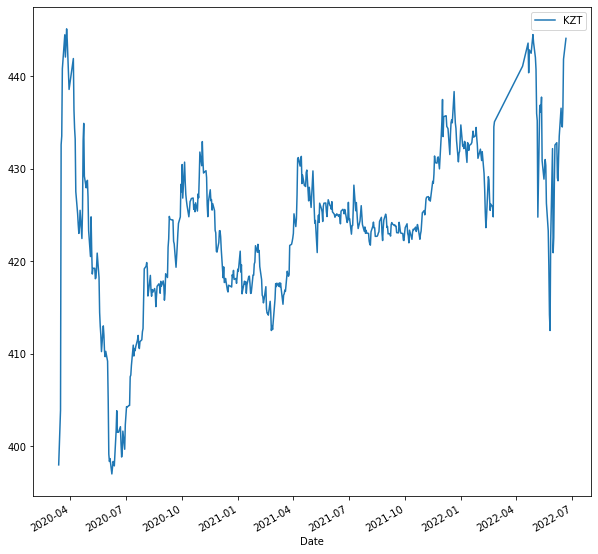

In [207]:
import matplotlib.pyplot as plt

data.plot(x="Date", y="KZT", figsize=(10, 10))
plt.show()

In [214]:
data = data.set_index('Date')

,KZT
count,546.000000
mean,423.481832
std,8.584833
min,396.980000
25%,418.362500
50%,424.055000
75%,428.380000
max,445.110000


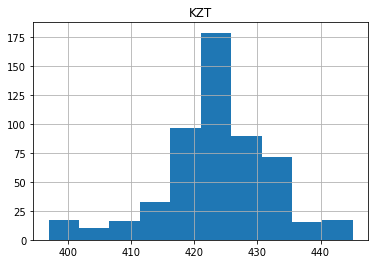

In [215]:
itog = data.describe()
data.hist()
itog

In [216]:
print('V = %f' % (itog.std()[0]/itog.mean()[0]))

V = 0.411971


In [226]:
test = sm.tsa.adfuller(data)
print( 'adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -2.005956858474517
p-value:  0.28396734784190425
Critical values:  {'1%': -3.442819521824351, '5%': -2.8670399588708047, '10%': -2.5696992792614384}
есть единичные корни, ряд не стационарен


In [227]:
data1_diff = data.diff(periods=1).dropna()

In [228]:
test = sm.tsa.adfuller(data1_diff)
print( 'adf: ', test[0] )
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -4.6397958172756555
p-value:  0.00010902535539842768
Critical values:  {'1%': -3.4427957890025533, '5%': -2.867029512430173, '10%': -2.5696937122646926}
единичных корней нет, ряд стационарен


<AxesSubplot:xlabel='Date'>

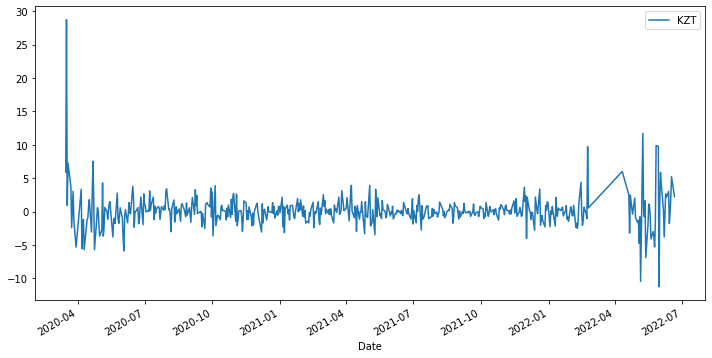

In [229]:
data1_diff.plot(figsize=(12,6))

In [307]:
src_data_model = data[:'2022-05-01']
src_data_model = src_data_model.resample('W').mean()
model = sm.tsa.ARIMA(src_data_model, order=(1,1,1), freq='W').fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [308]:
print (model.summary())

                               SARIMAX Results                                
Dep. Variable:                    KZT   No. Observations:                  112
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -302.180
Date:                Fri, 02 Jun 2023   AIC                            610.359
Time:                        08:00:50   BIC                            618.488
Sample:                    03-15-2020   HQIC                           613.657
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8999      0.105      8.599      0.000       0.695       1.105
ma.L1         -0.9596      0.112     -8.551      0.000      -1.180      -0.740
sigma2        18.1816      0.945     19.240      0.0

In [309]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

pred = model.predict('2022-05-01','2022-09-01', typ='levels')
trn = data['2022-05-01':'2022-05-25']
r2 = r2_score(trn, pred[1:])
print ('R^2: %1.2f' % r2)

R^2: -0.82


In [310]:
mean_squared_error(trn,pred[1:])

94.6040589648801

In [311]:
mean_absolute_error(trn,pred[1:])

7.701510200122196

<AxesSubplot:xlabel='Date'>

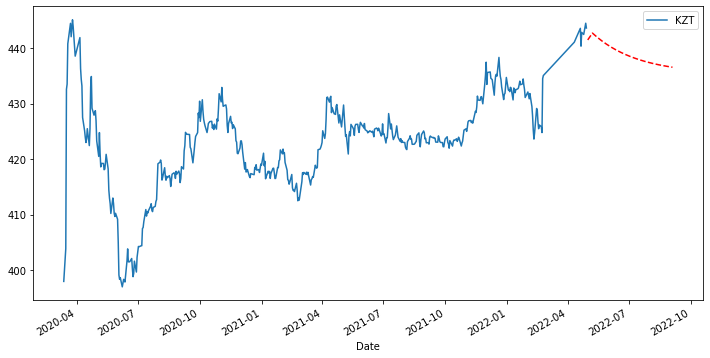

In [291]:
data[:'2022-05-01'].plot(figsize=(12,6))
pred.plot(style='r--')

In [312]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(model.resid.dropna())

0.8568896427450242